# Análise de Microdados de Matrícula

Este notebook realiza análises de predição de evasão escolar usando três algoritmos de machine learning:
1. **Random Forest**: Classificação supervisionada (ensemble method)
2. **Neural Network**: Deep learning com PyTorch (CUDA-accelerated)
3. **Linear Discriminant Analysis (LDA)**: Análise discriminante linear

Todos os modelos fornecem métricas completas de avaliação: **Accuracy, Precision, Recall, F1 Score, ROC-AUC**.

In [1]:
from zipfile import ZipFile

# Tentar usar RAPIDS com fallback pras libs normais
try:
	import cudf as pd
except ImportError:
	import pandas as pd

from algoritmos import LDAAnalysis, NeuralNetworkAnalysis, RandomForestAnalysis

## 1. Carregamento dos Dados

In [2]:
IS_USING_RAPIDS = 'cudf' in pd.__name__
print(f'Usando RAPIDS: {IS_USING_RAPIDS}')

Usando RAPIDS: False


In [3]:
DF_KWARGS = {'sep': ';'} if IS_USING_RAPIDS else {'encoding': 'utf8', 'on_bad_lines': 'warn', 'sep': ';'}

# Carregando todos os .csv como um dataframe só
print('Carregando dados...')
with ZipFile('Microdados_Matricula.zip', 'r') as zip_file:
	dataframes = []

	for year in [2021, 2022, 2023]:
		csv_filename = f'microdados_matriculas_{year}.csv'
		print(f'Lendo {csv_filename}...')

		with zip_file.open(csv_filename) as csv_file:
			_df = pd.read_csv(csv_file, **DF_KWARGS)
			dataframes.append(_df)

	df = pd.concat(dataframes, ignore_index=True)

print(f'\nDados carregados: {len(df)} registros')
df.head()

Carregando dados...
Lendo microdados_matriculas_2021.csv...
Lendo microdados_matriculas_2022.csv...
Lendo microdados_matriculas_2023.csv...

Dados carregados: 4717935 registros


,Ano,Carga Horaria,Carga Horaria Mínima,Categoria da Situação,Co Inst,Cod Unidade,Cor / Raça,Código da Matricula,Código da Unidade de Ensino - SISTEC,Código do Ciclo Matricula,...,Vagas Extraordinárias l9,Vagas Regulares AC,Vagas Regulares l1,Vagas Regulares l10,Vagas Regulares l13,Vagas Regulares l14,Vagas Regulares l2,Vagas Regulares l5,Vagas Regulares l6,Vagas Regulares l9
0,2021,200,200.0,Evadidos,26243,557,Amarela,96176470,3479.0,2716099,...,0.0,850.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,2021,160,160.0,Em curso,26436,6002,Amarela,102483972,45430.0,2830452,...,0.0,2834.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,2021,160,160.0,Em curso,26436,6002,Amarela,102459282,45430.0,2830437,...,0.0,1234.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,2021,40,160.0,Em curso,26419,116,Amarela,97887414,2936.0,2745532,...,0.0,265.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,2021,1380,1200.0,Em curso,26404,436,Amarela,91646798,2947.0,2632269,...,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


## 2. Configuração das Colunas

In [4]:
EVAL_COLUMN = 'Categoria da Situação'  # A coluna que a gente quer prever
WANTED_COLUMNS = (
	'Ano',
	'Carga Horaria',
	'Carga Horaria Mínima',
	'Co Inst',
	'Cod Unidade',
	'Cor / Raça',
	'Código da Unidade de Ensino - SISTEC',
	'Código do Município com DV',
	'Data de Fim Previsto do Ciclo',
	'Data de Inicio do Ciclo',
	'Eixo Tecnológico',
	'Faixa Etária',
	'Fator Esforço Curso',
	'Fonte de Financiamento',
	'Idade',
	'Instituição',
	'Matrícula Atendida',
	'Modalidade de Ensino',
	'Município',
	'Nome de Curso',
	'Região',
	'Renda Familiar',
	'Sexo',
	'Subeixo Tecnológico',
	'Tipo de Curso',
	'Tipo de Oferta',
	'Total de Inscritos',
	'Turno',
	'UF',
	'Unidade de Ensino',
	'Vagas Extraordinárias AC',
	'Vagas Extraordinárias l1',
	'Vagas Extraordinárias l10',
	'Vagas Extraordinárias l13',
	'Vagas Extraordinárias l14',
	'Vagas Extraordinárias l2',
	'Vagas Extraordinárias l5',
	'Vagas Extraordinárias l6',
	'Vagas Extraordinárias l9',
	'Vagas Regulares AC',
	'Vagas Regulares l1',
	'Vagas Regulares l10',
	'Vagas Regulares l13',
	'Vagas Regulares l14',
	'Vagas Regulares l2',
	'Vagas Regulares l5',
	'Vagas Regulares l6',
	'Vagas Regulares l9',
)  # As colunas que fazem sentido ser avaliadas

print(f'Coluna alvo: {EVAL_COLUMN}')
print(f'Total de features: {len(WANTED_COLUMNS)}')

Coluna alvo: Categoria da Situação
Total de features: 48


## 3. Random Forest Analysis

Análise supervisionada usando Random Forest para predição de evasão.

RANDOM FOREST ANALYSIS - Predição de Evasão Escolar
Preprocessando dados...

Distribuição das classes (antes):
Categoria da Situação
Em curso       0.361439
Evadidos       0.179843
Concluintes    0.163807
Em Curso       0.147949
Concluídos     0.146963
Name: proportion, dtype: float64

Distribuição das classes (depois):
Categoria da Situação
1    0.820157
0    0.179843
Name: proportion, dtype: float64

Dados preprocessados!

Calculando correlações...

Top 10 correlações:
Cod Unidade                             0.366456
Código da Unidade de Ensino - SISTEC    0.366248
Unidade de Ensino                       0.365517
Código do Município com DV              0.335940
Instituição                             0.335858
Vagas Regulares AC                      0.327602
Data de Fim Previsto do Ciclo           0.327014
Total de Inscritos                      0.315324
Data de Inicio do Ciclo                 0.313140
Carga Horaria                           0.307483
dtype: float64

Treinando modelo R

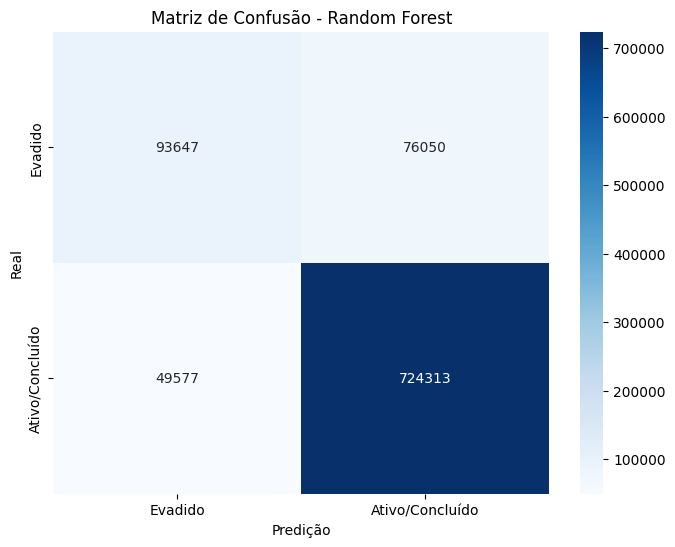


Gerando visualização de features...


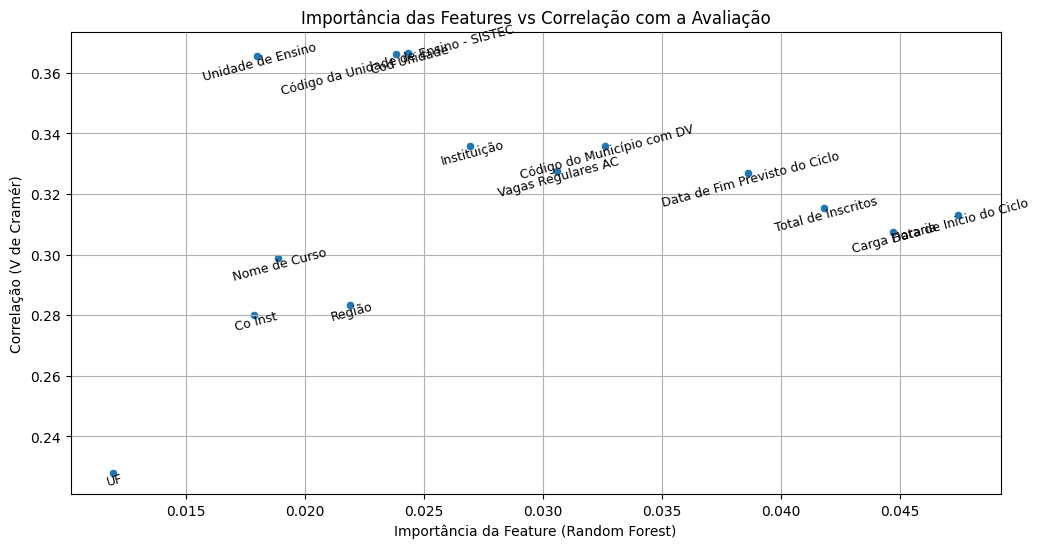


Análise de features salva em feature_analysis.csv
Métricas de avaliação salvas em random_forest_metrics.csv

Análise Random Forest concluída!


In [5]:
# Criar e executar análise Random Forest
rf_analysis = RandomForestAnalysis(df, EVAL_COLUMN, WANTED_COLUMNS)
rf_analysis.run()

## 4. Neural Network Analysis

Análise supervisionada usando Deep Learning (PyTorch) com aceleração CUDA.

NEURAL NETWORK ANALYSIS - Predição de Evasão Escolar
Preprocessando dados...
Dispositivo: cpu

Distribuição das classes (antes):
Categoria da Situação
Em curso       0.361439
Evadidos       0.179843
Concluintes    0.163807
Em Curso       0.147949
Concluídos     0.146963
Name: proportion, dtype: float64

Distribuição das classes (depois):
Categoria da Situação
1    0.820157
0    0.179843
Name: proportion, dtype: float64

Dados preprocessados!

Preparando dataloaders (batch_size=1024)...
Train: 3396913 samples
Validation: 377435 samples
Test: 943587 samples

Treinando Neural Network (20 epochs)...
Epoch 1/20 - Train Loss: 0.3750, Train Acc: 0.8544 - Val Loss: 0.3512, Val Acc: 0.8615
Epoch 5/20 - Train Loss: 0.3467, Train Acc: 0.8632 - Val Loss: 0.3364, Val Acc: 0.8657
Epoch 10/20 - Train Loss: 0.3422, Train Acc: 0.8645 - Val Loss: 0.3316, Val Acc: 0.8669
Epoch 15/20 - Train Loss: 0.3403, Train Acc: 0.8648 - Val Loss: 0.3297, Val Acc: 0.8675
Epoch 20/20 - Train Loss: 0.3391, Train Acc: 0.

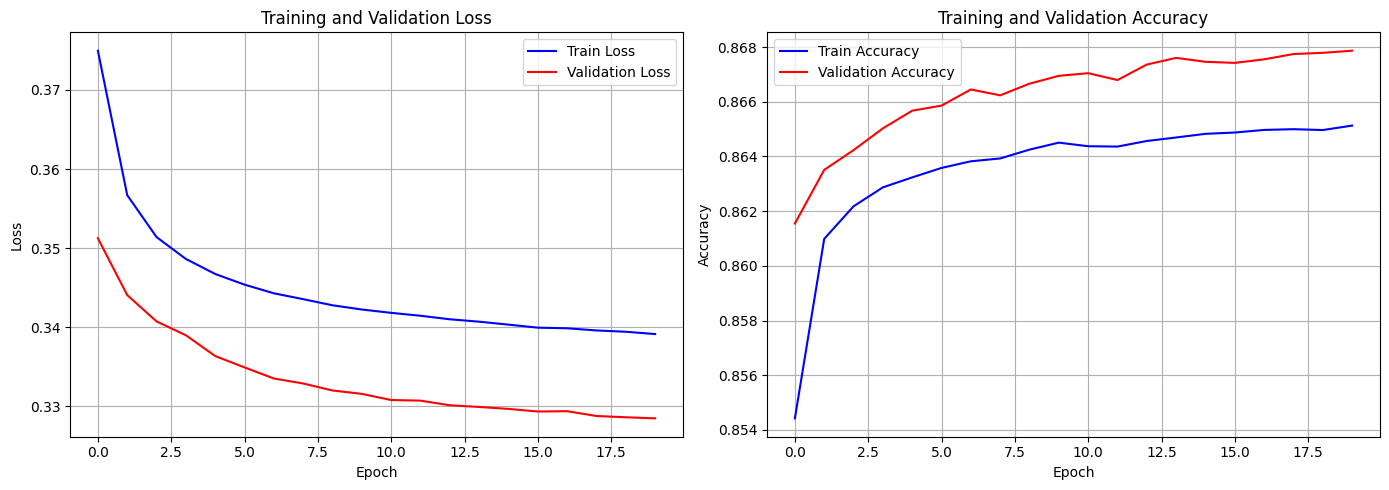


Gerando matriz de confusão...


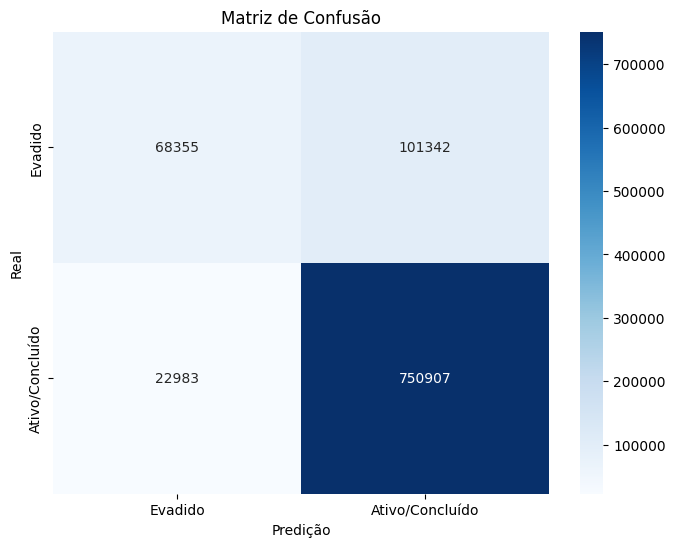


Gerando curva ROC...


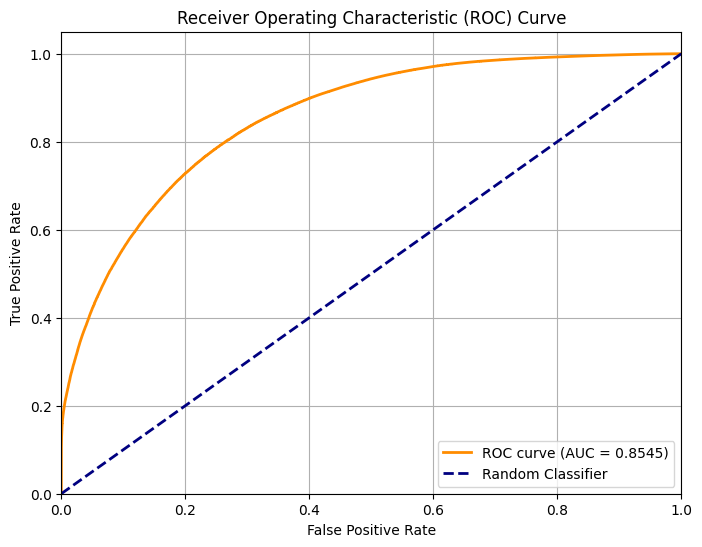


Modelo salvo em dropout_model.pth

Histórico de treinamento salvo em neural_network_training_history.csv
Métricas de avaliação salvas em neural_network_metrics.csv

Análise Neural Network concluída!


In [6]:
# Criar e executar análise Neural Network
# Nota: Este algoritmo usa aceleração CUDA se disponível (GPU)
nn_analysis = NeuralNetworkAnalysis(df, EVAL_COLUMN, WANTED_COLUMNS)
nn_analysis.run(epochs=20, batch_size=1024, lr=0.001)

## 5. Linear Discriminant Analysis (LDA)

Análise supervisionada usando Linear Discriminant Analysis para predição de evasão.

LINEAR DISCRIMINANT ANALYSIS - Predição de Evasão Escolar
Preprocessando dados...

Distribuição das classes (antes):
Categoria da Situação
Em curso       0.361439
Evadidos       0.179843
Concluintes    0.163807
Em Curso       0.147949
Concluídos     0.146963
Name: proportion, dtype: float64

Distribuição das classes (depois):
Categoria da Situação
1    0.820157
0    0.179843
Name: proportion, dtype: float64

Dados preprocessados!

Treinando modelo LDA (solver=svd)...
Treinamento concluído!

Avaliando modelo no conjunto de teste...

MÉTRICAS DE AVALIAÇÃO
Accuracy:  0.8320
Precision: 0.8412
Recall:    0.9802
F1 Score:  0.9054
ROC-AUC:   0.6978

Relatório de Classificação Detalhado:
                 precision    recall  f1-score   support

        Evadido       0.63      0.16      0.25    169697
Ativo/Concluído       0.84      0.98      0.91    773890

       accuracy                           0.83    943587
      macro avg       0.74      0.57      0.58    943587
   weighted avg       0.

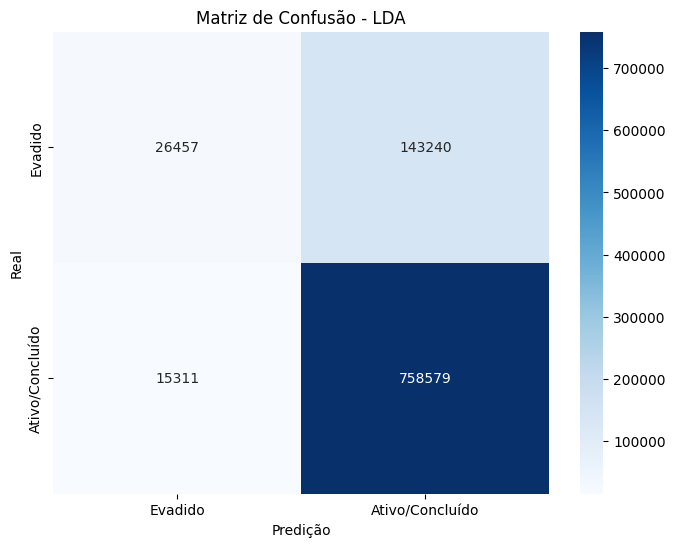


Gerando curva ROC...


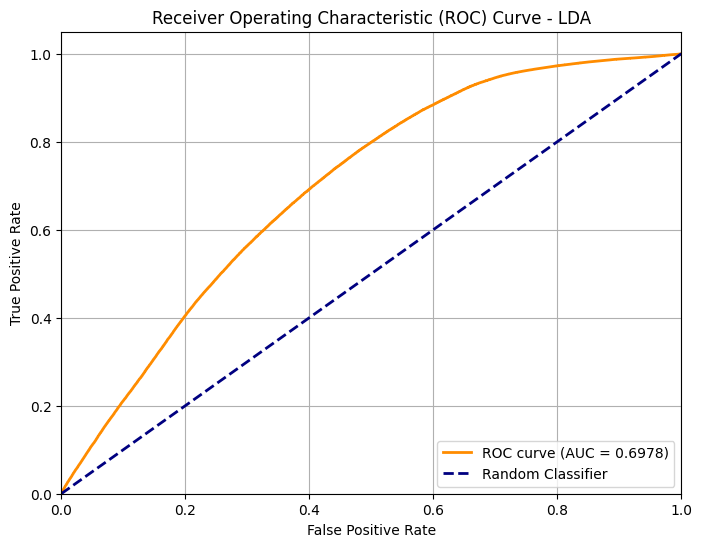


Gerando distribuição de scores discriminantes...


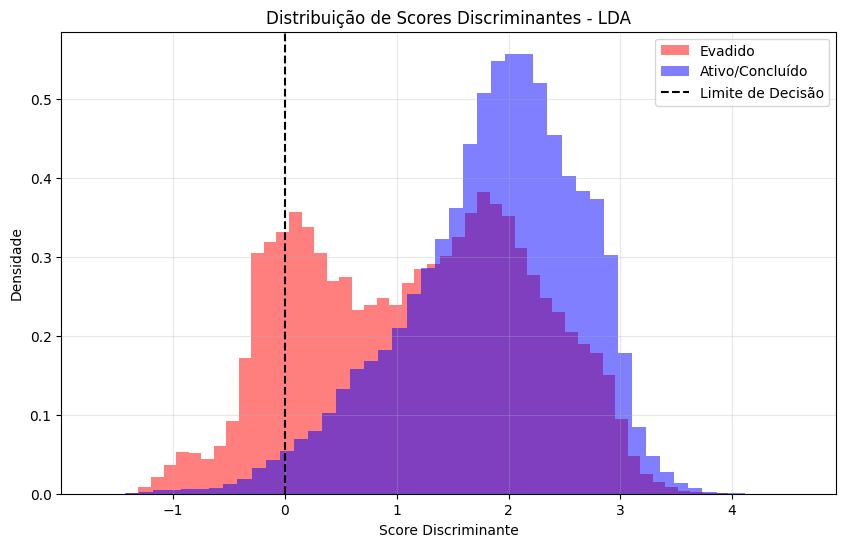


Métricas de avaliação salvas em lda_metrics.csv

Análise LDA concluída!


In [7]:
# Criar e executar análise LDA
lda_analysis = LDAAnalysis(df, EVAL_COLUMN, WANTED_COLUMNS)
lda_analysis.run()

## 6. Conclusão

- **Random Forest**: Classificação supervisionada usando ensemble de árvores de decisão
  - Fornece predições de evasão e importância das features
  - **Métricas**: Accuracy, Precision, Recall, F1 Score
  - Matriz de confusão para análise de erros
  - Robusto contra overfitting e bom para interpretar importância de variáveis
  
- **Neural Network**: Deep learning com PyTorch (CUDA-accelerated)
  - Modelo de redes neurais profundas com múltiplas camadas
  - Usa aceleração GPU (CUDA) quando disponível
  - **Métricas**: Accuracy, Precision, Recall, F1 Score, ROC-AUC
  - Fornece predições com métricas avançadas e curva ROC
  - Melhor capacidade de modelar relações não-lineares complexas

- **Linear Discriminant Analysis (LDA)**: Análise discriminante linear
  - Método estatístico que encontra combinações lineares de features que melhor separam as classes
  - Redução de dimensionalidade e classificação simultaneamente
  - **Métricas**: Accuracy, Precision, Recall, F1 Score, ROC-AUC
  - Fornece scores discriminantes e distribuição de classes
  - Assume normalidade multivariada e homogeneidade de covariância
  - Computacionalmente eficiente e interpretável

### Arquivos Gerados

Os resultados foram salvos em:
- `feature_analysis.csv` - Análise de importância de features (Random Forest)
- `random_forest_metrics.csv` - **Métricas de avaliação do Random Forest**
- `neural_network_training_history.csv` - Histórico de treinamento da Neural Network
- `neural_network_metrics.csv` - **Métricas de avaliação da Neural Network**
- `lda_metrics.csv` - **Métricas de avaliação do LDA**
- `dropout_model.pth` - Modelo Neural Network treinado (PyTorch)

### Métricas Utilizadas

Os modelos fornecem as seguintes métricas de avaliação:

| Métrica | Descrição |
|---------|-----------|
| **Accuracy** | Proporção de predições corretas |
| **Precision** | Proporção de positivos preditos que são realmente positivos |
| **Recall** | Proporção de positivos reais que foram corretamente identificados |
| **F1 Score** | Média harmônica entre Precision e Recall |
| **ROC-AUC** | Área sob a curva ROC (Neural Network e LDA) |